### Installation of Required Libraries and Browser

This cell installs all the Python libraries and dependencies needed for the scraping workflow.

- **Playwright**: automates browser actions to scrape dynamic web pages  
- **Pandas**: used for creating and manipulating dataframes  
- **BeautifulSoup4**: parses HTML content from web pages  
- **nest_asyncio**: enables asynchronous code execution in notebooks
- **Chromium**: used for Playwright to improve efficiency for scraping

In [1]:
# Install Playwright and other dependencies
!pip install playwright pandas beautifulsoup4 nest_asyncio

# Install only Chromium browser for Playwright for efficiency
!playwright install chromium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 15.9 MB/s eta 0:00:00
173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 5.6s173.7 MiB [] 1% 2.7s173.7 MiB [] 1% 2.5s173.7 MiB [] 2% 2.1s173.7 MiB [] 3% 2.0s173.7 MiB [] 4% 1.9s173.7 MiB [] 5% 2.1s173.7 MiB [] 6% 2.1s173.7 MiB [] 7% 2.1s173.7 MiB [] 8% 2.1s173.7 MiB [] 9% 2.1s173.7 MiB [] 10% 2.1s173.7 MiB [] 11% 1.9s173.7 MiB [] 12% 1.9s173.7 MiB [] 13% 1.8s173.7 MiB [] 14% 1.8s173.7 MiB [] 16% 1.7s173.7 MiB [] 17% 1.6s173.7 MiB [] 18% 1.5s173.7 MiB [] 20% 1.5s173.7 MiB [] 22% 1.4s173.7 MiB [] 23% 1.4s173.7 MiB [] 24% 1.4s173.7 MiB [] 25% 1.3s173.7 MiB [] 26% 1.4s173.7 MiB [] 26% 1.5s173.7 MiB [] 27% 1.5s173.7 MiB [] 27% 1.4s173.7 MiB [] 28% 1.4s173.7 MiB [] 29% 1.4s173.7 MiB [] 30% 1.4s173.7 MiB [] 31% 1.3s173.7 MiB [] 32% 1.3s173.7 MiB [] 33% 1.3s173.7 MiB [] 34% 1.3s173.7 MiB [] 35% 1.2s173.7 MiB [] 36% 1.2s173.7 MiB [] 37% 1.2s173.7 MiB [] 39% 1.1s173.7 MiB [] 40% 1.1s173.7 MiB [] 41% 1.1s173.7 MiB [] 42% 1.1s173.7 MiB [] 43% 1.0s173.7 MiB

### Importing Libraries

This cell imports all the libraries required for scraping, analysis, and refinement of output.

- **asyncio**: allows running asynchronous code, which is integral for Playwright to handle multiple web requests efficiently  
- **pandas**: used for creating, manipulating, and analyzing tabular data  
- **BeautifulSoup**: used for web scraping
- **Playwright (async_api)**: automates browser actions to scrape dynamic content from websites
- **tqdm.notebook**: provides progress bars in Jupyter/Colab notebooks to track long-running loops

In [2]:
import asyncio
import pandas as pd
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
from tqdm.notebook import tqdm

### Initializing Playwright Browser

This function sets Playwright up for web scraping.

- **Starts Playwright** asynchronously  
- **Launches a headless Chromium browser**, meaning it runs in the background without opening a visible window  
- **Creates a new browser context** to isolate browsing sessions  
- **Opens a new page** for navigation and scraping  

In [3]:
async def init_playwright():
    p = await async_playwright().start()
    browser = await p.chromium.launch(headless=True)
    context = await browser.new_context()
    page = await context.new_page()
    return p, browser, context, page

### Retrieving Collection Links

This function collects URLs for all Ready-to-Wear collections for a given season and year.

- Constructs the ***Vogue Runway* URL** for the specified season and year  
- Navigates to the page asynchronously using Playwright with a timeout of 150 seconds
- “Waits until the DOM content is loaded (wait_until='domcontentloaded') before scraping”
- Uses a short **polite delay** (`asyncio.sleep`) to avoid overloading the server  
- Finds all `<a>` tags containing `/fashion-shows/` in their `href` attribute  
- Converts **relative URLs to absolute URLs** and returns a list of collection links
- Returns a list of all valid collection links for that season

In [4]:
async def get_listing_links(page, season, year):
    """Retrieve collection links for a given season and year."""
    url = f"https://www.vogue.com/fashion-shows/{season}-{year}-ready-to-wear"
    try:
        # Increased timeout to 150 seconds
        await page.goto(url, wait_until="domcontentloaded", timeout=150000)
        await asyncio.sleep(2)  # polite delay
    except Exception as e:
        print(f"Failed to load {url}: {e}")
        return []

    # Collect all anchor tags linking to fashion show pages
    links = await page.eval_on_selector_all("a[href*='/fashion-shows/']", "els => els.map(el => el.href)")
    return links

### Scraping Collection Details

This function extracts detailed information from an individual Vogue Ready-to-Wear collection page:

- **Navigates to the collection URL** using Playwright with a timeout of 150 seconds and waits until the DOM content is loaded
- **Parses HTML content** with BeautifulSoup
- **Extracts brand and designer names**, using fallback logic if tags are missing
- **Determines the fashion week** ( New York Fashion Week (NYFW), Paris Fashion Week (PFW), Milan Fashion Week (MFW), and London Fashion Week (LFW)) based on URL or meta tags  
- **Records the publication date** of the collection article
- **Identifies the gender line** (Women, Men, or Unisex) from the title
- **Collects style keywords** by scanning meta descriptions and relevant HTML tags to detect any of 24 predefined style keywords
- **Counts the number of looks** and **unique models** in the collection (defaults to look count if no model images are found)
- Returns all collected information as a **dictionary** for further use in the main scraping workflow

In [5]:
async def scrape_collection(page, link, season, year):
    try:
        await page.goto(link, timeout=150000, wait_until="domcontentloaded") # Increased timeout to 150 seconds
        await asyncio.sleep(1)
    except Exception as e:
        print(f"Failed to load {link}: {e}")
        return None

    soup = BeautifulSoup(await page.content(), "html.parser")

    # Brand
    title_tag = soup.find("h1")
    title = title_tag.get_text(strip=True) if title_tag else "Unknown Brand"

    # Designer
    h2 = soup.find("h2")
    designer = h2.get_text(strip=True) if h2 else (title.split(" - ")[0] if " - " in title else "Unknown Designer")

    # Fashion Week detection
    url_lower = link.lower()
    meta_content = ""
    meta_section = soup.find("meta", {"property": "article:section"})
    if meta_section and meta_section.get("content"):
        meta_content = meta_section["content"].lower().strip()

    combined_text = url_lower + " " + meta_content

    import re
    if re.search(r"new[- ]york", combined_text):
        fashion_week = "NYFW"
    elif re.search(r"paris", combined_text):
        fashion_week = "PFW"
    elif re.search(r"milan", combined_text):
        fashion_week = "MFW"
    elif re.search(r"london", combined_text):
        fashion_week = "LFW"
    else:
        fashion_week = "Unknown"

    # Date Published
    date_tag = soup.find("meta", {"property": "article:published_time"})
    date_published = date_tag["content"] if date_tag else "Unknown Date"

    # Gender Line
    gender_line = "Unisex"
    if "Women" in title:
        gender_line = "Women"
    elif "Men" in title:
        gender_line = "Men"

    # Keywords
    fashion_terms = [
        "minimalist", "maximalist", "streetwear", "avant-garde", "grunge", "bohemian",
        "punk", "preppy", "tailored", "retro", "vintage", "romantic", "utilitarian",
        "futuristic", "gothic", "athleisure", "artsy", "feminine", "androgynous",
        "classic", "bold", "structured", "deconstructed", "layered"
    ]
    keywords = []
    meta_desc = soup.find("meta", {"name": "description"})
    if meta_desc and meta_desc.get("content"):
        desc = meta_desc["content"].lower()
        for term in fashion_terms:
            if term in desc:
                keywords.append(term)

    for tag in soup.find_all(["h2","h3","p","span"]):
        txt = tag.get_text(strip=True).lower()
        for term in fashion_terms:
            if term in txt:
                keywords.append(term)


    keywords = ", ".join(sorted(set(keywords))) if keywords else "No Style Keywords"

    # Look Count
    look_imgs = soup.find_all("img", class_=lambda c: c and ("gallery" in c.lower() or "slide" in c.lower()))
    look_count = len(look_imgs) if look_imgs else 1

    # Model Count
    model_imgs = soup.find_all("img", alt=True)
    model_names = {img["alt"].strip() for img in model_imgs if "model" in img["alt"].lower()}
    model_count = len(model_names) if model_names else look_count


    return {
        "Brand": title,
        "Link": link,
        "Year": year,
        "Season": season,  # Pass in capitalized season from main
        "Designer": designer,
        "Fashion Week": fashion_week,
        "Date Published": date_published,
        "Source": "Vogue",
        "Model Count": model_count,
        "Look Count": look_count,
        "Keywords": keywords,
        "Gender Line": gender_line
    }

### Scraping a Collection with Concurrency Control

This helper function wraps the `scrape_collection` function to manage concurrent page scraping.

- **Limits concurrency** using an `asyncio.Semaphore` so that only a set number of pages are scraped at the same time  
- **Opens a new Playwright page** for each collection to avoid sharing a page across tasks  
- **Calls `scrape_collection`** to extract all collection details (brand, designer, fashion week, keywords, look count, model count, etc.)  
- **Ensures the page is closed** after scraping, even if an error occurs  
- Returns the dictionary of scraped collection information for further processing


In [6]:
async def scrape_collection_with_semaphore(semaphore, context, link, season, year):
    """Wrapper to scrape a collection with concurrency control."""
    async with semaphore:
        page = await context.new_page()
        try:
            return await scrape_collection(page, link, season, year)
        finally:
            await page.close()

### Scraping an Entire Season Concurrently

This function handles scraping all collections for a given season and year, using concurrency to speed up the process.

- **Retrieves all collection links** for the specified season via `get_listing_links()`  
- **Prints the number of collections** found for the season  
- **Launches concurrent scraping tasks** for each collection using `scrape_collection_with_semaphore()`  
- **Limits concurrency** according to the provided semaphore to avoid overloading the browser or Vogue's servers  
- **Uses `asyncio.as_completed` with tqdm** to display a progress bar while tasks are running  
- **Collects the results** (dictionaries of collection data) into a list  
- Returns the list of all scraped collection information for the season

In [7]:
async def scrape_season(season, year, semaphore, context):
    """Scrape all collections for a given season and year concurrently."""
    all_data = []
    links = await get_listing_links(context.pages[0], season, year)
    print(f"Found {len(links)} collections for {season.capitalize()} {year}")

    # Launch scraping tasks concurrently
    tasks = [
        scrape_collection_with_semaphore(semaphore, context, link, season, year)
        for link in links
    ]
    for future in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc=f"Scraping {season.capitalize()} collections"):
        row = await future
        if row:
            all_data.append(row)
    return all_data

### Running the Main Scraper

This asynchronous function orchestrates the full scraping workflow.

- **Defines seasons and year** to scrape (Spring/Summer and Fall/Winter 2024, but only Spring and Fall 2024 in the function since *Vogue* has changed their code to only include the former season for each fashion season)  
- **Initializes Playwright** and opens a headless Chromium browser  
- **Iterates through each season**, retrieving all collection links from *Vogue Runway* via `scrape_season()` (which internally uses `get_listing_links()` and manages concurrency)  
- **Scrapes collection pages concurrently** (5 pages at a time) using a semaphore to limit concurrency  
- Uses **tqdm progress bars** to avoid an overload of outputs when scraping
- **Polite delay** (`asyncio.sleep(1)`) included to avoid overloading the server  
- **Closes the browser** and Playwright context after scraping  
- **Converts collected data to a Pandas DataFrame**, saves it as a CSV file, and displays it
- Each collection page is scraped with a **timeout of 150 seconds**


In [8]:
async def main():
    """Main function to orchestrate the scraping."""
    seasons = ["spring", "fall"]
    year = 2024
    all_data = []

    semaphore = asyncio.Semaphore(5)  # limit concurrency to 5 pages at once
    p, browser, context, page = await init_playwright()

    for season in seasons:
        print(f"\n=== Scraping {season.capitalize()} {year} ===")
        season_data = await scrape_season(season, year, semaphore, context)
        all_data.extend(season_data)

    # Close browser and context
    await context.close()
    await browser.close()
    await p.stop()

    # Save DataFrame
    df = pd.DataFrame(all_data)
    df.to_csv(f"vogue_ready_to_wear_{year}.csv", index=False)
    print(f"\n🎉 Scraping complete! Saved {len(all_data)} rows.")
    display(df)
    return df

# Run the scraper
df = await main()



=== Scraping Spring 2024 ===
Found 423 collections for Spring 2024


Scraping Spring collections:   0%|          | 0/423 [00:00<?, ?it/s]


=== Scraping Fall 2024 ===
Found 411 collections for Fall 2024


Scraping Fall collections:   0%|          | 0/411 [00:00<?, ?it/s]


🎉 Scraping complete! Saved 834 rows.


,Brand,Link,Year,Season,Designer,Fashion Week,Date Published,Source,Model Count,Look Count,Keywords,Gender Line
0,Tiger of Sweden,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-06-21T07:00:00.000Z,Vogue,1,1,classic,Unisex
1,Miu Miu,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-10-03T12:32:58.281Z,Vogue,1,1,No Style Keywords,Unisex
2,Adeam,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-10T20:32:48.757Z,Vogue,1,1,"athleisure, layered, romantic",Unisex
3,Emilia Wickstead,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-18T10:25:45.487Z,Vogue,1,1,bold,Unisex
4,Blumarine,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-21T17:48:17.088Z,Vogue,1,1,No Style Keywords,Unisex
...,...,...,...,...,...,...,...,...,...,...,...,...
829,House of Aama,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-14T00:35:20.794Z,Vogue,1,1,No Style Keywords,Unisex
830,Khaite,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-11T15:49:16.696Z,Vogue,1,1,No Style Keywords,Unisex
831,House of Dagmar,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-27T17:21:25.898Z,Vogue,1,1,No Style Keywords,Unisex
832,Susan Fang,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-19T14:36:18.692Z,Vogue,1,1,minimalist,Unisex


### Renaming Category for Accuracy

Fashion seasons are split into Spring/Summer and Fall/Winter, so the season value has been renamed to be accurate.

In [9]:
# Rename season values for clarity
df["Season"] = df["Season"].replace({
    "Spring": "Spring/Summer",
    "Fall": "Fall/Winter"
})

# Display DataFrame
print("\nDataFrame with Season Values Renamed:")
display(df)


DataFrame with Season Values Renamed:


,Brand,Link,Year,Season,Designer,Fashion Week,Date Published,Source,Model Count,Look Count,Keywords,Gender Line
0,Tiger of Sweden,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-06-21T07:00:00.000Z,Vogue,1,1,classic,Unisex
1,Miu Miu,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-10-03T12:32:58.281Z,Vogue,1,1,No Style Keywords,Unisex
2,Adeam,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-10T20:32:48.757Z,Vogue,1,1,"athleisure, layered, romantic",Unisex
3,Emilia Wickstead,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-18T10:25:45.487Z,Vogue,1,1,bold,Unisex
4,Blumarine,https://www.vogue.com/fashion-shows/spring-202...,2024,spring,,Unknown,2023-09-21T17:48:17.088Z,Vogue,1,1,No Style Keywords,Unisex
...,...,...,...,...,...,...,...,...,...,...,...,...
829,House of Aama,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-14T00:35:20.794Z,Vogue,1,1,No Style Keywords,Unisex
830,Khaite,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-11T15:49:16.696Z,Vogue,1,1,No Style Keywords,Unisex
831,House of Dagmar,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-27T17:21:25.898Z,Vogue,1,1,No Style Keywords,Unisex
832,Susan Fang,https://www.vogue.com/fashion-shows/fall-2024-...,2024,fall,,Unknown,2024-02-19T14:36:18.692Z,Vogue,1,1,minimalist,Unisex


### **Driving Question**: Did the most popular/common brands' collections match the most popular/common styles? If so, did that trend follow the industry's opinion of what the popular styles are for that year or season? Did the most influential brands in 2024 lead trends or follow consumerist style trends?

### Figure 1: Heatmap of Most Popular/Common Brands v. Styles

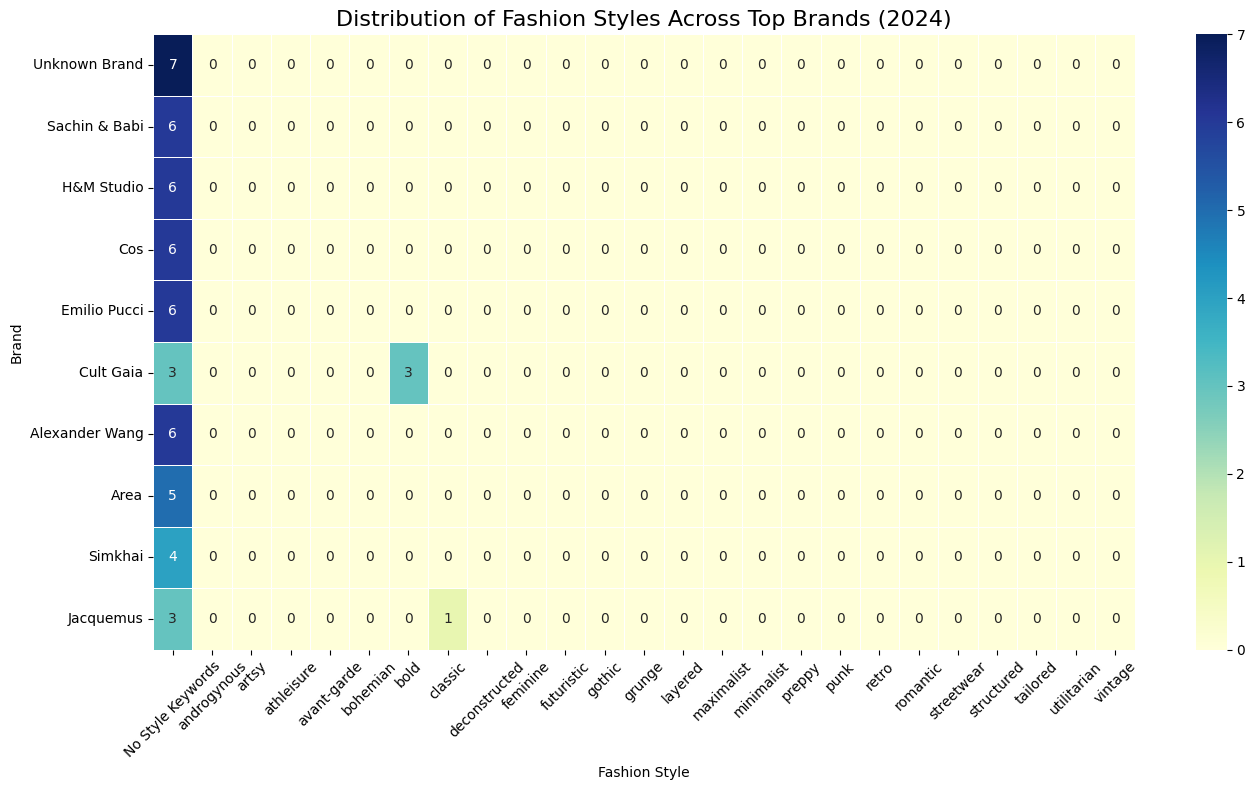

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Explode the 'Keywords' column so each keyword has its own row
df_exploded = df.copy()
df_exploded['Keywords'] = df_exploded['Keywords'].str.split(', ')
df_exploded = df_exploded.explode('Keywords')

# Create a pivot table: count of collections per brand per style
brand_style_counts = df_exploded.pivot_table(
    index='Brand',
    columns='Keywords',
    values='Link',
    aggfunc='count',
    fill_value=0
)

# Focus on top 10 brands by total collections
top_brands = df['Brand'].value_counts().head(10).index
brand_style_counts_top = brand_style_counts.loc[top_brands]

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(brand_style_counts_top, cmap="YlGnBu", linewidths=0.5, annot=True, fmt='d')
plt.title("Distribution of Fashion Styles Across Top Brands (2024)", fontsize=16)
plt.xlabel("Fashion Style")
plt.ylabel("Brand")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Figure 1 Analysis

- Top 10 brands (ignoring Unknown Brand: Sachin & Babi, H&M Studio, Cos, Emilio Pucci, Cult Gaia, Alexander Wang, Area, Simkhai, and Jacquemus) are displayed via their collection counts
- Lack of information for the driving question
  - Likely due to the scraping method not working effectively for all brands since minimal results were yielded for different fashion styles
  - Did not pursue further due to time restrictions and the execution time of scraping


### **Driving Question**: Which brands or designers had the most looks for each season?

### Figures 2-3: Bar Graph of Top 10 Brands by Look Count per Season

/tmp/ipython-input-1415368850.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands['Brand'], y=top_brands['Look Count'], palette='tab20')


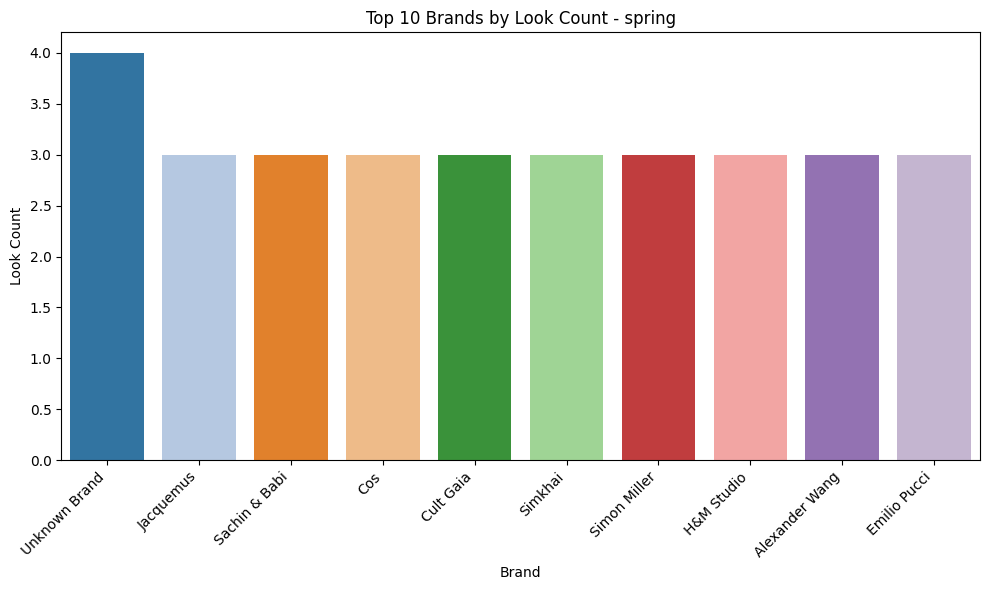

/tmp/ipython-input-1415368850.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands['Brand'], y=top_brands['Look Count'], palette='tab20')


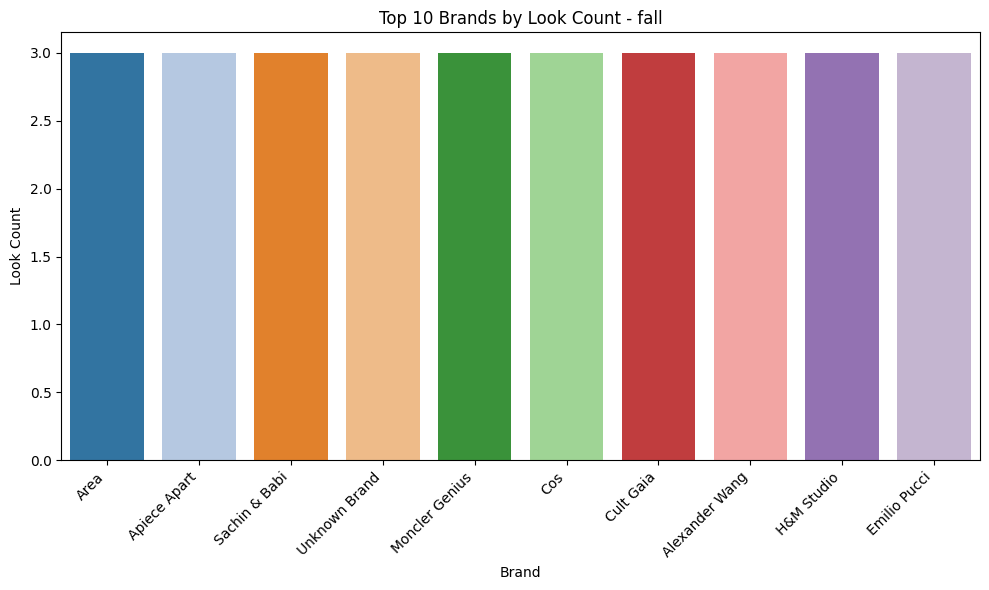

In [21]:
seasons = df['Season'].unique()

for season in seasons:
    season_df = df[df['Season'] == season]

    # Aggregate look counts by brand
    brand_look_counts = season_df.groupby('Brand')['Look Count'].sum().reset_index()

    # Top 10 brands
    top_brands = brand_look_counts.sort_values(by='Look Count', ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_brands['Brand'], y=top_brands['Look Count'], palette='tab20')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Brand')
    plt.ylabel('Look Count')
    plt.title(f'Top 10 Brands by Look Count - {season}')
    plt.tight_layout()
    plt.show()

### Figures 2-3 Analysis

- Top 10 brands by look count for each season are displayed (disregarding Unknown Brand)
  - *Spring/Summer*: Jacquemus, Sachin & Babi, Cos, Cult Gaia, Sumkhai, Simon Miller, H&M Studio, Alexander Wang, and Emilio Pucci with three looks
  - *Fall/Winter*: Area, Apiece Apart, Sachin & Babi, Moncler Genius, Cos, Cult Gaia, Alexander Wang, H&M Studio, and Emilio Pucci with three looks
- Look Count = number of <img> tags detected in gallery/slide classes
  - Default = 1 if none are found
  - Works well for typical *Vogue* gallery pages, but may miss images if the HTML structure is different or if images are lazy-loaded dynamically, which appears to be what happened since the look count is very clearly far too little and the dataframe only says 1 look count
  - DId not pursue further due to time restrictions and the execution time of scraping

### **Driving Question**: Did a specific fashion week yield more brands? Were there more looks presented in a specific fashion week? If so, what could be the reason?

### Figure 4: Bar Graph of Average Number of Looks per Brand by Fashion Week

/tmp/ipython-input-1981374047.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


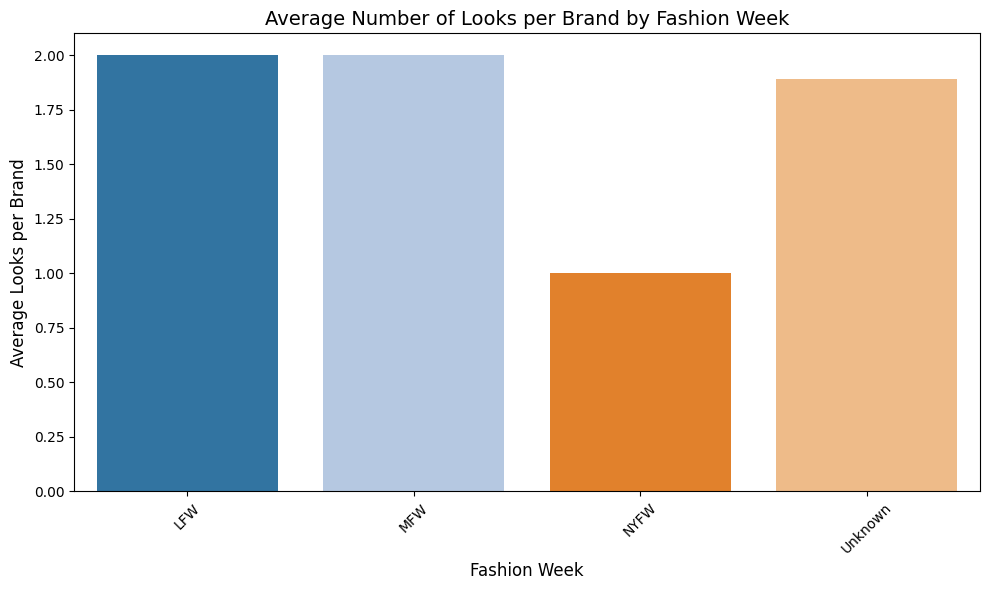

In [14]:
# Group by 'Fashion Week' to calculate the number of unique brands, total number of looks, and average looks per brand
avg_looks = df.groupby('Fashion Week').agg({'Brand':'nunique', 'Look Count':'sum'})
avg_looks['Avg Looks per Brand'] = avg_looks['Look Count'] / avg_looks['Brand']
avg_looks = avg_looks.reset_index()

# Create a bar chart to visualize average looks per brand
plt.figure(figsize=(10,6))
sns.barplot(
    x='Fashion Week',
    y='Avg Looks per Brand',
    data=avg_looks,
    palette='tab20'
)

# Add labels and title
plt.xlabel('Fashion Week', fontsize=12)
plt.ylabel('Average Looks per Brand', fontsize=12)
plt.title('Average Number of Looks per Brand by Fashion Week', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Display plot
plt.show()

### Figure 4 Analysis

- Three fashion week locations (and unkown value) with the average number of looks per brand by Fashion Week
  - London Fashion Week and Milan Fashion Week with an average of two looks
  - New York Fashion Week with an average of one look
- Lack of information for the driving question due to flaws with collecting look count and fashion weeks
  - Did not pursue further due to time restrictions and the execution time of scraping